# Init

In [1]:
import glob
import numpy as np
import datetime as dt
import pytz
from tensorflow.python.summary import summary_iterator
def get_events(run, x_axis='step'):
  """Returns event dictionary for given run, has form
  {tag1: {step1: val1}, tag2: ..}

  If x_axis is set to "time", step is replaced by timestamp
  """
  result = {}
  for fname in glob.glob(f'/efs/runs/{run}/events*'):
    print("Parsing "+fname)
    events = summary_iterator.summary_iterator(fname)

    for event in events:
      if x_axis == 'step':
        x_val = event.step
      elif x_axis == 'time':
        x_val = event.wall_time
      else:
        assert False, f"Unknown x_axis ({x_axis})"
        
      vals = {val.tag: val.simple_value for val in event.summary.value}
      # step_time: value
      for tag in vals:
        event_dict = result.setdefault(tag, {})
        if x_val in event_dict:
          print(f"Warning, overwriting {tag} for {x_axis}={x_val}")
          print(f"old val={event_dict[x_val]}")
          print(f"new val={vals[tag]}")

        event_dict[x_val] = vals[tag]
        
  return result

def datetime_from_seconds(seconds, timezone="US/Pacific"):
  """
  timezone: pytz timezone name to use for conversion, ie, UTC or US/Pacific
  """
  return dt.datetime.fromtimestamp(seconds, pytz.timezone(timezone))

def plot(d):
    xs = [item[0] for item in d.items()]
    ys = [item[1] for item in d.items()]
    plt.plot(xs, ys)
def plot2(d1,d2):
    xs1 = [item[0] for item in d1.items()]
    ys1 = [item[1] for item in d1.items()]
    xs2 = [item[0] for item in d2.items()]
    ys2 = [item[1] for item in d2.items()]
    plt.plot(xs1, ys1, xs2, ys2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Queries

## Tracking down event line break

Parsing /efs/runs/deleteme/events.out.tfevents.1533146384.ip-192-168-45-167
Parsing /efs/runs/wed-two-machines/events.out.tfevents.1533146908.ip-192-168-42-161


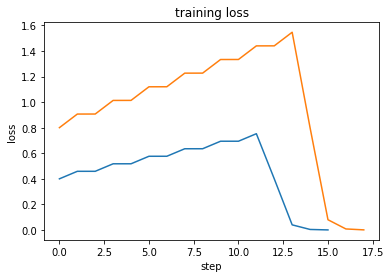

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
events_dict=get_events('deleteme')
events1 = events_dict['lr']
events_dict=get_events('wed-two-machines')
events2 = events_dict['lr']
plt.ylabel('loss')
plt.xlabel('step')
plt.title("training loss")
plt.plot(events1.values())
plt.plot(events2.values())

In [8]:
events1

{1536: 0.400070458650589,
 1282560: 0.4588235318660736,
 1284096: 0.4588939845561981,
 2565120: 0.5176470875740051,
 2566656: 0.5177174806594849,
 3847680: 0.5764706134796143,
 3849216: 0.576541006565094,
 5130240: 0.6352941393852234,
 5131776: 0.6353645920753479,
 6412800: 0.6941176652908325,
 6414336: 0.694188117980957,
 7695360: 0.7529411911964417,
 7696896: 0.4000000059604645,
 26935296: 0.03999999910593033,
 44891136: 0.004000000189989805,
 55150080: 0.00039999998989515007}

In [9]:
events2

{3072: 0.8002551794052124,
 1284096: 0.9066666960716248,
 1287168: 0.9069218635559082,
 2568192: 1.0133333206176758,
 2571264: 1.013588547706604,
 3852288: 1.1200000047683716,
 3855360: 1.1202552318572998,
 5136384: 1.2266666889190674,
 5139456: 1.226921796798706,
 6420480: 1.3333333730697632,
 6423552: 1.3335884809494019,
 7704576: 1.440000057220459,
 7707648: 1.4402551651000977,
 8988672: 1.5466666221618652,
 8991744: 0.800000011920929,
 30821376: 0.07999999821186066,
 50082816: 0.00800000037997961,
 61634560: 0.0007999999797903001}

In [ ]:
peak #1 at 7695360
peak #2 at 8988672
batch_size1 = 1536
batch_size2 = 3072
log every: 30720 examples 

## Figure out frequency of spikes

In [ ]:
peak #1 at 7695360
peak #2 at 8988672
batch_size1 = 1536
batch_size2 = 3072
log every: 30720 examples 

Parsing /efs/runs/pillow-one/events.out.tfevents.1533160638.ip-192-168-39-101
Parsing /efs/runs/pillow-two/events.out.tfevents.1533160937.ip-192-168-45-119


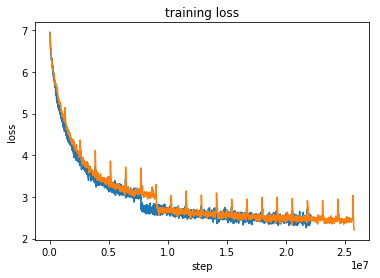

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
events_dict=get_events('pillow-one')
events1 = events_dict['losses/xent']
events_dict=get_events('pillow-two')
events2 = events_dict['losses/xent']
plt.ylabel('loss')
plt.xlabel('step')
plt.title("training loss")
plot2(events1, events2)

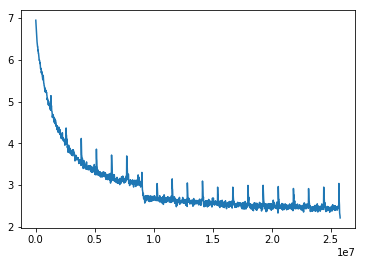

In [23]:
plot(events2)

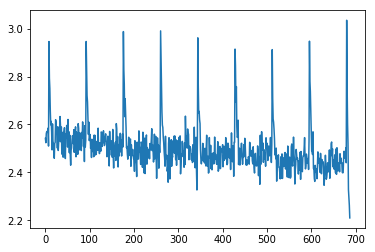

In [27]:
plt.plot(list(events2.values())[1000:])

In [30]:
def pos_top(a, k):
  """Positions of top k entries in a"""
  return sorted(range(len(a)), key=lambda i: a[i])[-k:]

In [37]:
# positions of peaks
peak_pos = sorted(pos_top(list(events2.values())[1000:], 9))

In [42]:
# step values of peaks
step_vals = np.array(list(events2.keys())[1000:])[peak_pos]

In [43]:
# deltas
np.ediff1d(step_vals)

array([1284096, 1284096, 1284096, 1284096, 1284096, 1284096, 1284096,
       1284096])

# Runs

## Thu 8-machine run

In [39]:
# Get test losses with timestamps
events_dict=get_events('thu-eight', 'time')
events = events_dict['losses/test_5']
for key in events:
  print(datetime_from_seconds(key).strftime("%Y-%m-%d_%H-%M-%S"), events[key])
  if events[key]>=93:
    end_time = key
    break

Parsing /efs/runs/thu-eight/events.out.tfevents.1533244938.ip-192-168-46-102
2018-08-02_14-24-21 13.640000343322754
2018-08-02_14-24-55 22.889999389648438
2018-08-02_14-25-27 37.18199920654297
2018-08-02_14-25-58 47.24599838256836
2018-08-02_14-26-29 40.4640007019043
2018-08-02_14-27-01 47.784000396728516
2018-08-02_14-27-32 59.805999755859375
2018-08-02_14-28-03 68.0820083618164
2018-08-02_14-28-34 66.62999725341797
2018-08-02_14-29-05 65.56000518798828
2018-08-02_14-29-35 68.77600860595703
2018-08-02_14-30-06 67.19600677490234
2018-08-02_14-30-36 69.59200286865234
2018-08-02_14-31-13 64.73600769042969
2018-08-02_14-31-43 69.56600189208984
2018-08-02_14-32-14 70.63999938964844
2018-08-02_14-33-28 73.73200225830078
2018-08-02_14-34-25 77.93399810791016
2018-08-02_14-35-22 75.27200317382812
2018-08-02_14-36-19 88.86599731445312
2018-08-02_14-37-15 89.11599731445312
2018-08-02_14-38-11 89.4219970703125
2018-08-02_14-39-08 89.73600006103516
2018-08-02_14-40-04 89.8239974975586
2018-08-02_

In [41]:
# Get time of first event (this is logged for first image)
events = events_dict['sizes/image']
for key in events:
  print(datetime_from_seconds(key).strftime("%Y-%m-%d_%H-%M-%S"), events[key])
  start_time = key
  break

2018-08-02_14-23-32 128.0


In [45]:
duration_sec = end_time-start_time

In [46]:
f"{duration_sec//60} minutes, {duration_sec%60} seconds"

'31.0 minutes, 3.370328903198242 seconds'

### Subtract evaluation time

In [49]:
# Get test losses with timestamps
events = events_dict['times/eval_sec']
total_eval_time = 0
for key in events:
  if key>end_time:
    break
  total_eval_time+=events[key]
  print(datetime_from_seconds(key).strftime("%Y-%m-%d_%H-%M-%S"), events[key])
print(f"Total eval time {total_eval_time} seconds")

2018-08-02_14-24-21 1.0485830307006836
2018-08-02_14-24-55 0.8416521549224854
2018-08-02_14-25-27 0.6570076942443848
2018-08-02_14-25-58 0.6457502841949463
2018-08-02_14-26-29 0.5125820636749268
2018-08-02_14-27-01 0.6995992660522461
2018-08-02_14-27-32 0.5794594287872314
2018-08-02_14-28-03 0.32988905906677246
2018-08-02_14-28-34 0.4296715259552002
2018-08-02_14-29-05 1.080749750137329
2018-08-02_14-29-35 0.31527209281921387
2018-08-02_14-30-06 0.4033780097961426
2018-08-02_14-30-36 0.2592480182647705
2018-08-02_14-31-13 0.296480655670166
2018-08-02_14-31-43 0.5900180339813232
2018-08-02_14-32-14 0.44431471824645996
2018-08-02_14-33-28 1.5437510013580322
2018-08-02_14-34-25 1.2639431953430176
2018-08-02_14-35-22 0.9580121040344238
2018-08-02_14-36-19 1.5423643589019775
2018-08-02_14-37-15 1.2222888469696045
2018-08-02_14-38-11 1.0792341232299805
2018-08-02_14-39-08 1.1477699279785156
2018-08-02_14-40-04 0.8725981712341309
2018-08-02_14-41-00 1.007411003112793
2018-08-02_14-41-57 1.300

In [50]:
adjusted_duration_sec = duration_sec - total_eval_time

In [51]:
f"{adjusted_duration_sec//60} minutes, {adjusted_duration_sec%60} seconds"

'30.0 minutes, 28.717504262924194 seconds'